[0.6875586873201336, 0.002018391226185695, 0.18636533656408855]
[3.6625099570669795, 1.5684595217862245, 4.745016919835695]


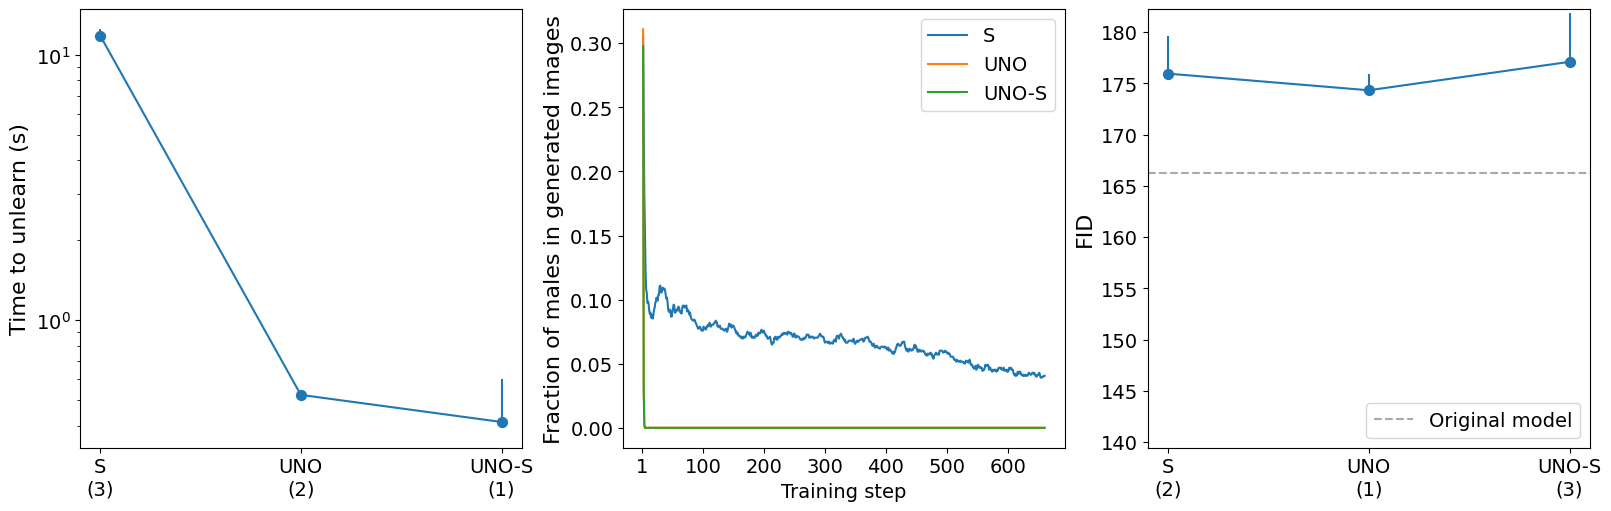

In [1]:
import os, sys, torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../../modules'))
sys.path.append(os.path.abspath('../../modules/celeba_male'))
import vae_train as vt
import vae_ortho as vo
import vae_surgery as vs
import vae_os as vos
import vae_ascent as va
import vae_ad as vad
import classifier as cl
import batch as bt
import utility as ut
import datapipe
import vae_viz as viz
from vae import VAE


device = ut.get_device()
root = '../../data/CelebA/CelebA-Experiments'
celeba_folder = '../../data/CelebA'
params = {
    "model": f"{celeba_folder}/vae/vae_200.pth",
    "latent_dim": 512,
    "num_steps": 50,
    "batch_size": 128,
    "log_interval": 1,
    "collect_interval": "epoch",
    "save_steps": "epoch",
    "all_classes": [0, 1],
    "forget_class": 1,
    "classifier_path": f"{celeba_folder}/cnn/cnn_10.pth",
    "kl_weight": 1,
    "total_duration": None,
    "data_path": f'{celeba_folder}/dataset',
    "max_data": None
}

algorithms = {"folders": [], "labels": [], }

# algorithms["folders"].append(f"{root}/vae-a")
# algorithms["labels"].append("A")

# algorithms["folders"].append(f"{root}/vae-ad")
# algorithms["labels"].append("AD")

# algorithms["folders"].append(f"{root}/vae-hat")
# algorithms["labels"].append(r"$\hat{.}$")

algorithms["folders"].append(f"{root}/vae-s")
algorithms["labels"].append("S")

# algorithms["folders"].append(f"{root}/vae-shat")
# algorithms["labels"].append(r"$\hat{S}$")

algorithms["folders"].append(f"{root}/vae-o")
algorithms["labels"].append(r"UNO")

# algorithms["folders"].append(f"{root}/vae-ohat")
# algorithms["labels"].append(r"$\hat{O}$")

algorithms["folders"].append(f"{root}/vae-os")
algorithms["labels"].append(r"UNO-S")

# algorithms["folders"].append(f"{root}/vae-ohatshat")
# algorithms["labels"].append(r"$\hat{O}\hat{S}$")

bc = bt.BatchCompare(algorithms["folders"], algorithms["labels"])
# bc.plot("8 Fraction", "3 Fraction")
bc.plot2(logs=[True, False], rank=True)
plt.savefig("../../plots/celeba.pdf", bbox_inches="tight")

**Transformation**

In [2]:
path_a = f'{celeba_folder}/vae/vae_200.pth'
path_b = f'{root}/vae-o/expr-0/checkpoints/vae_epoch_1.pth'
model_a = vt.init_model(path_a, 512, 'mps')
model_b = vt.init_model(path_b, 512, 'mps')
# fig, _ = viz.compare_model_outputs(model_a, model_b, num_samples=100, save_path=f'{root}/vae-o/expr-0/noise_3.npy')
# fig.savefig("../../plots/temp/celeba_large_gen.pdf", bbox_inches="tight")

**Create transformation plot**

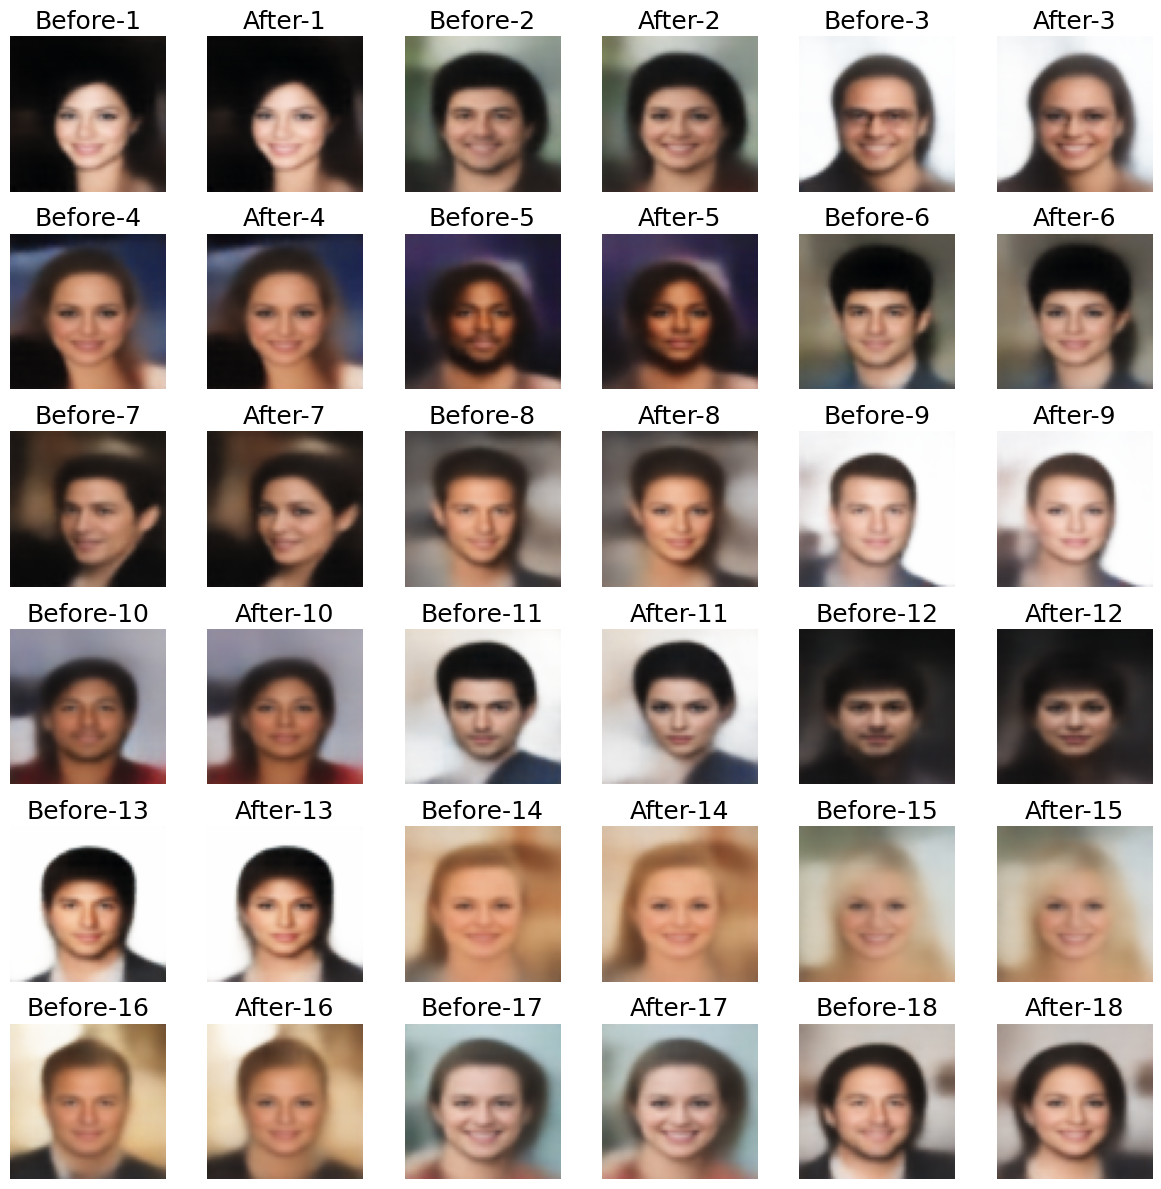

In [3]:
z0 = np.load(f'{root}/vae-o/expr-0/noise_0.npy')
z0m = z0[[63, 60]]

z1 = np.load(f'{root}/vae-o/expr-0/noise_1.npy')
z1m = z1[[46]]
z1f = z1[[28]]

z2 = np.load(f'{root}/vae-o/expr-0/noise_2.npy')
z2 = z2[[0, 5, 46, 84]]

z3 = np.load(f'{root}/vae-o/expr-0/noise_3.npy')
z3 = z3[[66, 26, 62, 63]]

z4 = np.load(f'{root}/vae-o/expr-0/noise_4.npy')
z4 = z4[[12]]

z5 = np.load(f'{root}/vae-o/expr-0/noise_5.npy')
z5 = z5[[61]]

z7 = np.load(f'{root}/vae-o/expr-0/noise_12.npy')
z7 = z7[[131, 114, 26, 109]]

z6 = np.load(f'{root}/vae-o/expr-0/noise_6.npy')

z = np.vstack([z0m, z1m, z1f, z2, z3, z4, z5, z7])

# np.random.shuffle(z)

fig, _ = viz.compare_model_outputs_2(model_a, model_b, num_samples=18, save_path=z[::-1].copy());
fig.savefig(f'../../plots/celeba_large_generation_comparison.pdf', bbox_inches="tight")

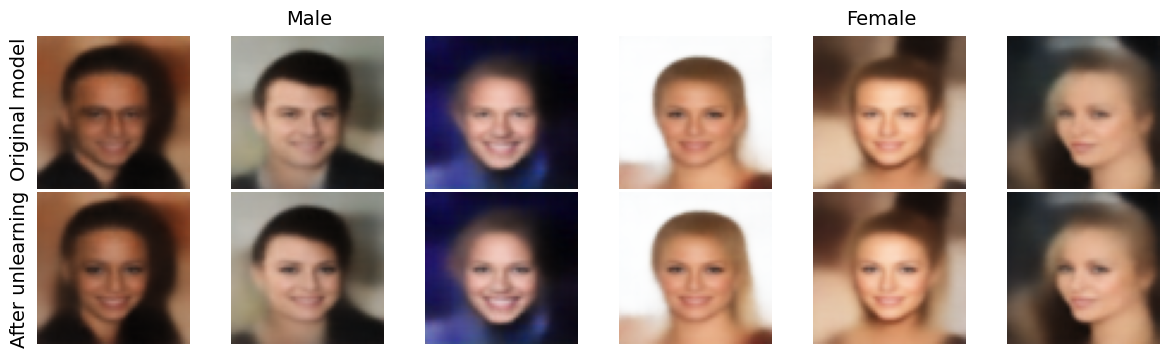

In [4]:
z0 = np.load(f'{root}/vae-o/expr-0/noise_0.npy')
# z0m = z0[[14, 63, 60]]
z0m = z0[[14]]
z1 = np.load(f'{root}/vae-o/expr-0/noise_1.npy')
# z1m = z1[[46, 50, 87, 88]]
z1m = z1[[50, 88]]
# z1f = z1[[28, 67, 76, 86]]
z1f = z1[[76, 86, 67]]

z = np.vstack([z0m, z1m, z1f])

viz.plot_transformation(model_a, model_b, z, save_path=f"../../plots/celeba_transformation.pdf");

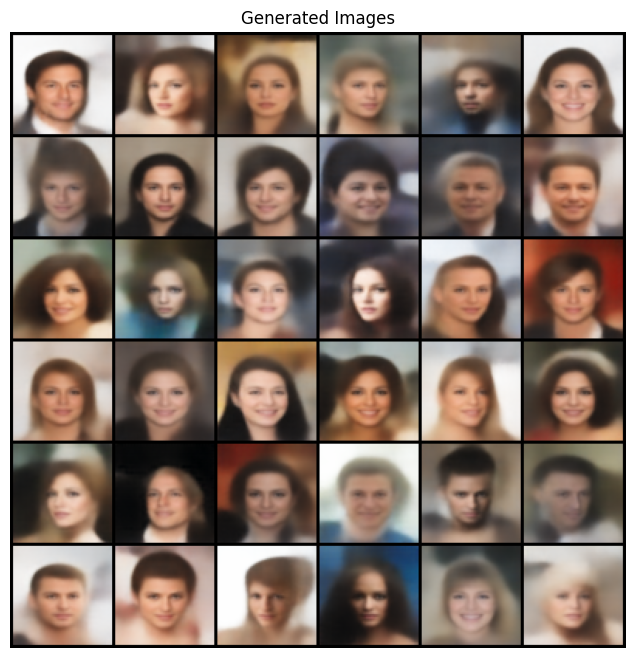

In [5]:
path = "../../data/CelebA/vae/vae_200.pth"
model = vt.init_model(path, 512, 'mps')
viz.generate_random_samples(model, 36);

In [4]:
train_kwargs = params | {"uniformity_weight": 1e3, "orthogonality_weight": 1e3, "forget_weight": 0.}
train_kwargs["folder"] = f"{root}/vae-ohatshat"
be = bt.BatchExperiment(vos.train, train_kwargs, 10)
summary, summary_std = be.summarize_wo_fid()
# be.compute_fid_from_folder(real_images, folder, batch_size=256)
# be.summarize(num_fid_samples=num_fid_samples, batch_size=fid_batch_size)

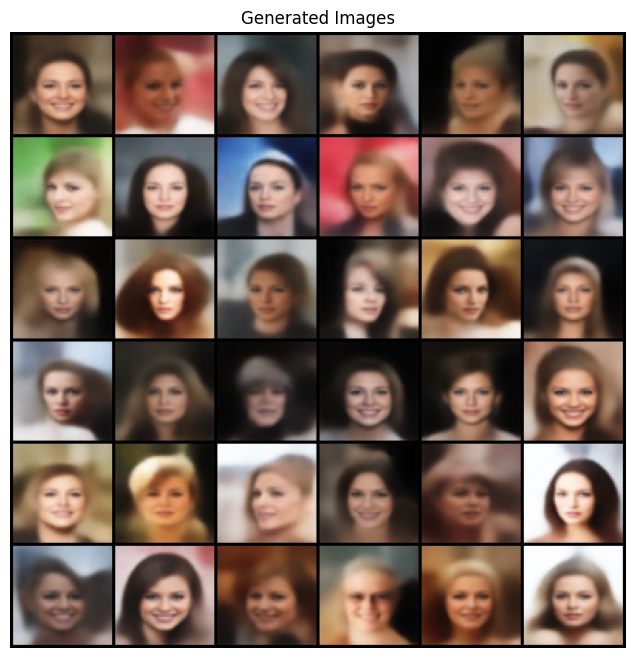

In [5]:
path = "../../data/CelebA/CelebA-Experiments/vae-ohatshat/expr-0/checkpoints/vae_epoch_1.pth"
model = vt.init_model(path, 512, 'mps')
viz.generate_random_samples(model, 36);

**New sample generation**

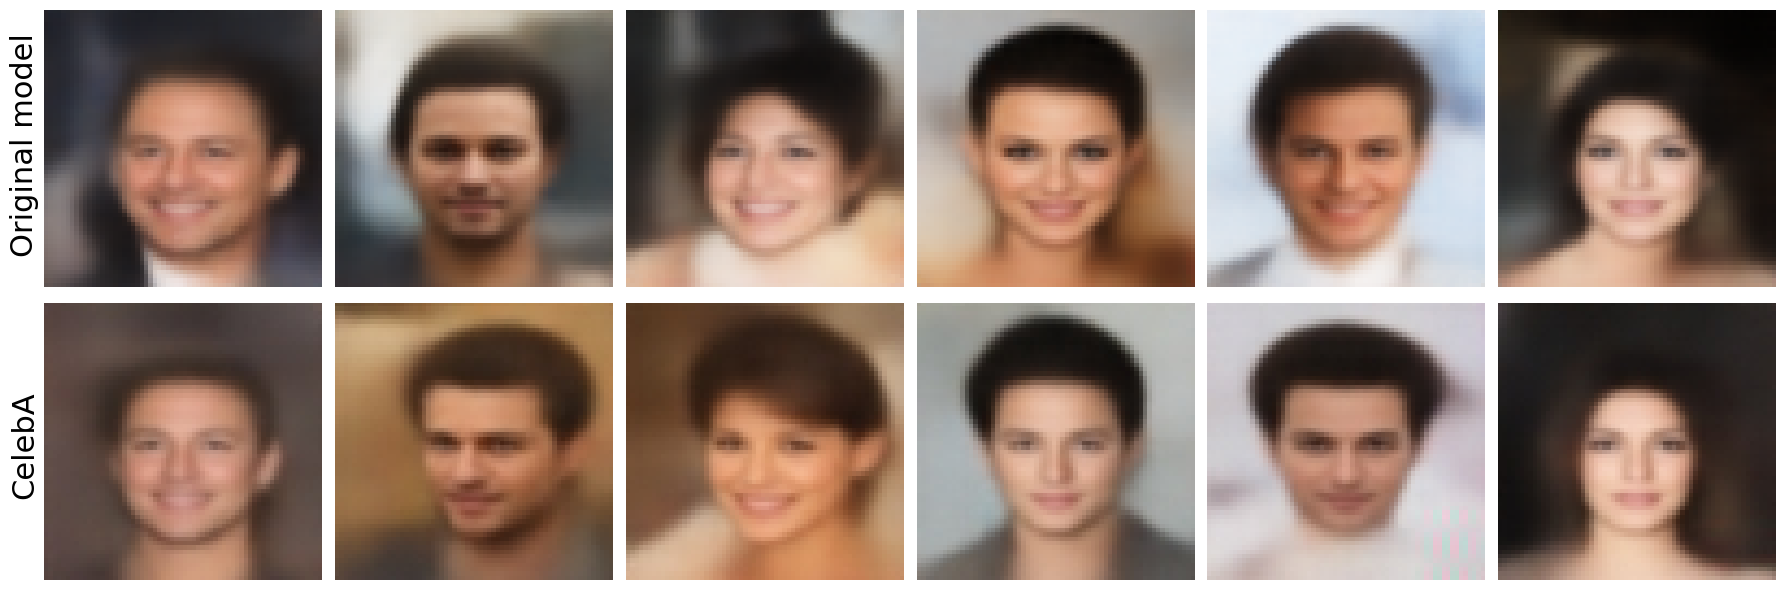

In [36]:
from PIL import Image

def visualize_generated_and_closest_images(
    model,
    feature_path='../../data/CelebA/vae/features_200.npy',
    image_dir='../../data/CelebA/dataset-reconstructed/img_align_celeba_reconstructed',
    seeds=[0, 1, 2, 3, 4, 5]
):
    device = next(model.parameters()).device
    features = torch.tensor(np.load(feature_path)).to(device)
    features = features.view(features.shape[0], -1)
    model.eval()

    gen_images = []
    closest_images = []

    for seed in seeds:
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Generate image from latent vector
        gen_img = model.decode(torch.randn(1, 512).to(device))

        # Encode and find closest
        feat = model.encoder(gen_img).view(1, -1)
        dists = torch.norm(features - feat, dim=1)
        closest_idx = torch.argmin(dists).item()

        # Load closest image from dataset
        filename = f"{closest_idx + 1:06d}.jpg"
        img_path = os.path.join(image_dir, filename)
        closest_img = Image.open(img_path).convert("RGB")

        # Convert generated image to numpy
        gen_img_np = gen_img.squeeze().detach().cpu().numpy()
        if gen_img_np.ndim == 3:
            gen_img_np = np.transpose(gen_img_np, (1, 2, 0))  # CHW → HWC

        gen_images.append(gen_img_np.clip(0, 1))
        closest_images.append(np.array(closest_img) / 255.0)

    # Plot 6 pairs (12 images) in a 2-row, 6-column grid
    fig, axes = plt.subplots(2, len(seeds), figsize=(3 * len(seeds), 6))

    for i in range(len(seeds)):
        axes[0, i].imshow(gen_images[i])
        # axes[0, i].set_title(f"Generated (Seed {seeds[i]})")
        axes[0, i].axis("off")

        axes[1, i].imshow(closest_images[i])
        # axes[1, i].set_title("Closest Match")
        axes[1, i].axis("off")
    

    # Add vertical labels to the left using fig.text
    fig.subplots_adjust(left=0.005, wspace=0.0, hspace=0.02)
    fig.text(0.0001, 0.75, "Original model", va='center', ha='left', rotation=90, fontsize=22)
    fig.text(0.0001, 0.25, "CelebA", va='center', ha='left', rotation=90, fontsize=22)

    plt.tight_layout()
    plt.show()

    return fig


fig = visualize_generated_and_closest_images(model_a, seeds=[91, 82, 100, 13, 14, 8])
fig.savefig('../../plots/originality.pdf', bbox_inches="tight")

Python 3.11.5


In [39]:
ut.count_params(model_a)

(8742659, 8742659)

In [43]:
ut.count_params(cl.get_classifier('../../data/CelebA/cnn/cnn_10.pth', 'mps'))

(2190913, 2190913)

In [5]:
n, device = 500, 'mps'
cls = cl.get_classifier('../../data/CelebA/cnn/cnn_10.pth', 'mps')
z_random = torch.randn(n, 512).to(device)
gen = model_a.decode(z_random)
logits = cls(gen)
cl.count_from_logits(logits)/500

0.33

In [8]:
145/500

0.29